# RWDL Deep Learning part

## Loading core libraries

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from PIL import ImageFile
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Input, Conv2DTranspose
import cv2
import seaborn as sns
sns.set_style('darkgrid')

## Declaration of basic constants

In [109]:
no_path = './wm-nowm/train/no-watermark/'
water_path = './wm-nowm/train/watermark/'
val_path_water = './wm-nowm/valid/watermark/'
val_path_nowater = './wm-nowm/valid/no-watermark/'
img_width, img_height = 128, 128
batch_size = 25
ImageFile.LOAD_TRUNCATED_IMAGES = True


## Base loading functions

In [110]:
def takeFileName(filedir): 
    filename = np.array(filedir.split('/'))[-1] 
    return filename

### Function to search for images in selections that have an answer

In [111]:
def matchFileNames(watermarkedarr, nonwatermarkedarr, dname_wm, dname_nwm):
    sortedwmarr = np.array([])
    sortednwmarr = np.array([])
    
    wmarr = list(watermarkedarr)
    nwmarr = list(nonwatermarkedarr)
    
    length = len(watermarkedarr) if len(watermarkedarr) >= len(nonwatermarkedarr) else len(nonwatermarkedarr)
    
    for pos in range(length):
        try:
            if length == len(watermarkedarr): 
                exist_nwm = nwmarr.index(wmarr[pos])
                sortedwmarr = np.append(sortedwmarr, dname_wm + watermarkedarr[pos])
                sortednwmarr = np.append(sortednwmarr, dname_nwm + nonwatermarkedarr[exist_nwm]) 
            elif length == len(nonwatermarkedarr): 
                exist_wm = wmarr.index(nwmarr[pos])
                sortedwmarr = np.append(sortedwmarr, dname_wm + watermarkedarr[exist_wm])
                sortednwmarr = np.append(sortednwmarr, dname_nwm + nonwatermarkedarr[pos])
        except ValueError: 
            continue
    return sortedwmarr, sortednwmarr

### Separation of images into training and test sets

In [112]:
tp_watermarked = np.array([]) 
tp_nonwatermarked = np.array([])

for root, dirs, files in os.walk(water_path, topdown=True): 
    for file in files:
        tp_watermarked = np.append(tp_watermarked, takeFileName(file)) 
    
for root, dirs, files in os.walk(no_path, topdown=True):
    for file in files:
        tp_nonwatermarked = np.append(tp_nonwatermarked, takeFileName(file)) 
        
tp_watermarked_sorted, tp_nonwatermarked_sorted = matchFileNames(tp_watermarked, tp_nonwatermarked, water_path, no_path)


val_watermarked = np.array([])
val_nonwatermarked = np.array([])

for root, dirs, files in os.walk(val_path_water, topdown=True): 
    for file in files:
        val_watermarked = np.append(val_watermarked, takeFileName(file))
    
for root, dirs, files in os.walk(val_path_nowater, topdown=True): 
    for file in files:
        val_nonwatermarked = np.append(val_nonwatermarked, takeFileName(file))
        
val_watermarked_sorted, val_nonwatermarked_sorted = matchFileNames(val_watermarked, val_nonwatermarked, val_path_water, val_path_nowater)

### Create images from the database

In [113]:
def createPixelArr(files, width, height):
    data = []
    for image in files:
        try: # take each image and use imread to get the pixel values in a matrix 
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # rescale the image so every image is of the same dimension
            data.append(resized_arr) # add the matrix of pixel values 
        except Exception as e:
            print(e)
    return np.array(data)

## Creating a training sample

In [114]:
xTrain = createPixelArr(tp_watermarked_sorted, img_width, img_height)
yTrain = createPixelArr(tp_nonwatermarked_sorted, img_width, img_height)
xVal = createPixelArr(val_watermarked_sorted, img_width, img_height)
yVal = createPixelArr(val_nonwatermarked_sorted, img_width, img_height)

**Normalizing data**

In [115]:
xTrain = xTrain / 255
yTrain = yTrain / 255
xVal = xVal / 255
yVal = yVal / 255

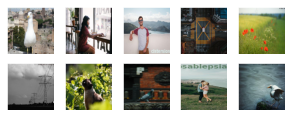

In [116]:
plt.figure(figsize=(5,5))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(xVal[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

## Autoencoder model

In [117]:
def baseAutoencoder(width, height):
    minWeight = width
    maxWeight = width * 2
    shape=(width, height, 3)
    img_input = Input((shape))

    x = Conv2D(minWeight, (3, 3), padding='same', activation='relu')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(minWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(maxWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Conv2D(maxWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    z = MaxPooling2D()(x)
    

    x = Conv2DTranspose(maxWeight, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x)
    
    x = Conv2D(maxWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Conv2D(maxWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 

    x = Conv2DTranspose(minWeight, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) 
    x = Conv2D(minWeight, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(minWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 

    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error') 

    return model 

In [118]:
modelAutoEncoder = baseAutoencoder(img_width, img_height)

In [42]:
history = modelAutoEncoder.fit(xTrain, yTrain, epochs=70, batch_size=1)

Epoch 1/70
1743/1743 [==============================] - 209s 118ms/step - loss: 0.0259
Epoch 2/70
1743/1743 [==============================] - 209s 120ms/step - loss: 0.0142
Epoch 3/70
1743/1743 [==============================] - 211s 121ms/step - loss: 0.0115
Epoch 4/70
1743/1743 [==============================] - 214s 123ms/step - loss: 0.0095
Epoch 5/70
1743/1743 [==============================] - 205s 118ms/step - loss: 0.0085
Epoch 6/70
1743/1743 [==============================] - 205s 118ms/step - loss: 0.0079
Epoch 7/70
1743/1743 [==============================] - 205s 118ms/step - loss: 0.0070
Epoch 8/70
1743/1743 [==============================] - 207s 119ms/step - loss: 0.0064
Epoch 9/70
1743/1743 [==============================] - 212s 121ms/step - loss: 0.0064
Epoch 10/70
1743/1743 [==============================] - 212s 121ms/step - loss: 0.0057
Epoch 11/70
1743/1743 [==============================] - 210s 120ms/step - loss: 0.0054
Epoch 12/70
1743/1743 [==================

In [119]:
modelAutoEncoder.save_weights('./modelAutoEncoder.h5') # Сохраняем модель

In [120]:
modelAutoEncoder = baseAutoencoder(img_width, img_height)
modelAutoEncoder.load_weights('./128.h5') # Загружаем модель

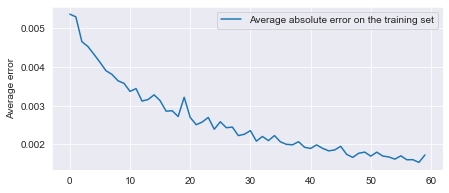

In [121]:
plt.figure(figsize=(7,3))
plt.plot(history.history['loss'][10:], 
         label='Average absolute error on the training set')
plt.ylabel('Average error')
plt.legend()
plt.show()

## Look at the results of the test sample

In [122]:
res = modelAutoEncoder.predict(xVal)
modelAutoEncoder.evaluate(xVal, res)

4/4 [==============================] - 1s 149ms/step - loss: 0.0000e+00


0.0

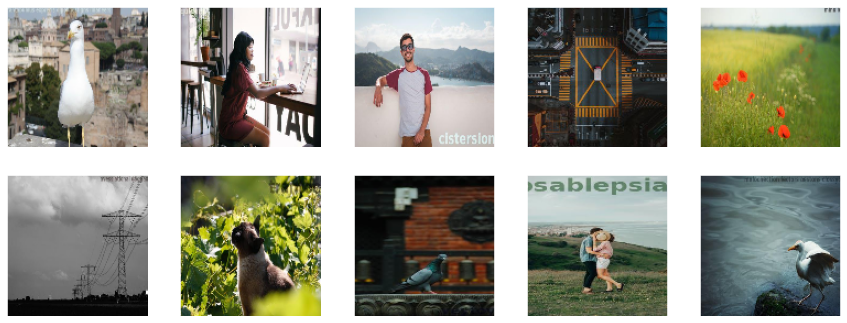

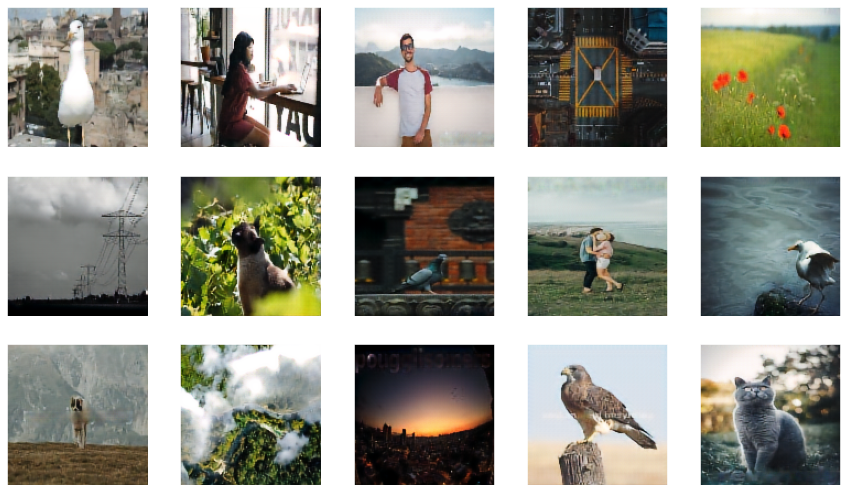

In [129]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(xVal[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()
plt.figure(figsize=(15,15))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(res[i], cv2.COLOR_BGR2RGB))
plt.show()